In [112]:
import os
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
from torch.fft import fft2, ifft2, fftshift, ifftshift
from models.PACT import PSF_PACT
from models.WienerNet import Wiener, WienerNet
from models.ResUNet import ResUNet
from models.Unrolled_ADMM import Unrolled_ADMM

%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Load in Test Data

In [113]:
data_path = '/mnt/WD6TB/tianaoli/dataset/SkinVessel_PACT/test/'
idx = 10000
gt = torch.from_numpy(np.load(os.path.join(data_path, 'gt', f"gt_{idx}.npy"))).float()
gt = (gt - gt.min()) / (gt.max() - gt.min()) # Normalize to [0, 1].
obs = torch.from_numpy(np.load(os.path.join(data_path, 'obs', f"obs_{idx}.npy"))).float()
obs = obs * gt.sum() / obs.sum(dim=[-2,-1]).unsqueeze(-1).unsqueeze(-1) # Normalize to the same flux.
obs = obs.to(device)

In [114]:
ncs = [32, 16, 8]
n_params = []

### Wiener

In [115]:
# psf_pact = PSF_PACT(delay_step=2e-4)
# psf_pact.to(device)
# model = Wiener()
# model.to(device)

In [116]:
# model.eval()
# with torch.no_grad():
#     psf = psf_pact(7.8e-4,0,0,0,0).to(device)
#     rec_wiener = model(obs.unsqueeze(0), psf, 0.01)
# rec_wiener = rec_wiener.squeeze(0).squeeze(0).detach().cpu()
# # psf = ifftshift(ifft2(fft2(obs[3])/fft2(rec))).real
# print(rec_wiener.shape)

In [117]:
# obs = obs.detach().cpu()
# psf = psf.squeeze(0).detach().cpu()

# fig = plt.figure(figsize=(15,8.5))
# for i in range(8):   
#     plt.subplot(4,8,i+1)
#     plt.imshow(obs[i])
#     # plt.imshow(ifft2(fft2(psf)*fft2(gt)).real)
#     plt.title('Observation', fontsize=12)
#     plt.axis('off')

#     ax1 = plt.subplot(4,8,i+9)
#     plt.imshow(rec_wiener[i])
#     plt.title('Reconstrcution', fontsize=12)
#     plt.axis('off')
#     # cax = fig.add_axes([ax1.get_position().x1+0.01, ax1.get_position().y0, 0.015, ax1.get_position().height])
#     # cb = plt.colorbar(cax=cax)

#     plt.subplot(4,8,i+17)
#     plt.imshow(psf[i])
#     plt.title('PSF', fontsize=12)
#     plt.axis('off')

#     ax4 = plt.subplot(4,8,i+25)
#     plt.imshow(fftshift(fft2(psf[i])).abs())
#     plt.title('Transfer Function', fontsize=12)
#     plt.axis('off')
#     # cax = fig.add_axes([ax4.get_position().x1+0.01, ax4.get_position().y0, 0.015, ax4.get_position().height])
#     # cb = plt.colorbar(cax=cax)

### ResUNet

In [118]:
rec_resunet = []
pretrained_epochs = [66, 80, 92]
for nc, pretrained_epoch in zip(ncs, pretrained_epochs):
    model = ResUNet(in_nc=8, out_nc=1, nb=2, nc=[nc, nc*2, nc*4, nc*8])
    model.to(device)
    n_params.append(sum([param.nelement() for param in model.parameters()]))
    loss = 'MSE'
    pretrained_file = os.path.join('../pretrained_models/', f'ResUNet_{nc}channels_{loss}_{pretrained_epoch}epochs.pth')
    model.load_state_dict(torch.load(pretrained_file, map_location=torch.device(device)))
    print('Successfully loaded in %s.', pretrained_file)
    model.eval()
    with torch.no_grad():
        rec = model(obs.unsqueeze(0))
    rec = rec.squeeze(0).squeeze(0).detach().cpu()
    rec_resunet.append(rec)

Successfully loaded in %s. ../pretrained_models/ResUNet_32channels_MSE_66epochs.pth
Successfully loaded in %s. ../pretrained_models/ResUNet_16channels_MSE_80epochs.pth
Successfully loaded in %s. ../pretrained_models/ResUNet_8channels_MSE_92epochs.pth


### Unrolled ADMM

In [119]:
# n_iters = 4
# model = Unrolled_ADMM(n_iters=n_iters)
# model.to(device)
# pretrained_epochs = 30
# loss = 'MSE'
# pretrained_file = os.path.join('../saved_models/', f'Unrolled_ADMM_{n_iters}iters_{loss}_{pretrained_epochs}epochs.pth')
# model.load_state_dict(torch.load(pretrained_file, map_location=torch.device(device)))
# print('Successfully loaded in %s.', pretrained_file)

In [120]:
# model.eval()
# with torch.no_grad():
#     rec = model(obs.unsqueeze(0).float())
# rec = rec.squeeze(0).squeeze(0).detach().cpu()
# print(rec.shape)

### WienerNet

In [121]:
rec_wienernet = []
pretrained_epochs = [82, 56, 96]
for nc, pretrained_epoch in zip(ncs, pretrained_epochs):
    model = WienerNet(nc=[nc, nc*2, nc*4, nc*8])
    model.to(device)
    loss = 'MSE' # 'MultiScale'
    pretrained_file = os.path.join('../pretrained_models/', f'WienerNet_{nc}channels_{loss}_{pretrained_epoch}epochs.pth')
    model.load_state_dict(torch.load(pretrained_file, map_location=torch.device(device)))
    print('Successfully loaded in %s.', pretrained_file)
    model.eval()
    with torch.no_grad():
        rec = model(obs.unsqueeze(0).float())
    rec = rec.squeeze(0).squeeze(0).detach().cpu()
    rec_wienernet.append(rec)

Successfully loaded in %s. ../pretrained_models/WienerNet_32channels_MSE_82epochs.pth
Successfully loaded in %s. ../pretrained_models/WienerNet_16channels_MSE_56epochs.pth
Successfully loaded in %s. ../pretrained_models/WienerNet_8channels_MSE_96epochs.pth


In [122]:
obs = obs.detach().cpu()
psf = ifftshift(ifft2(fft2(obs[3])/fft2(rec))).real

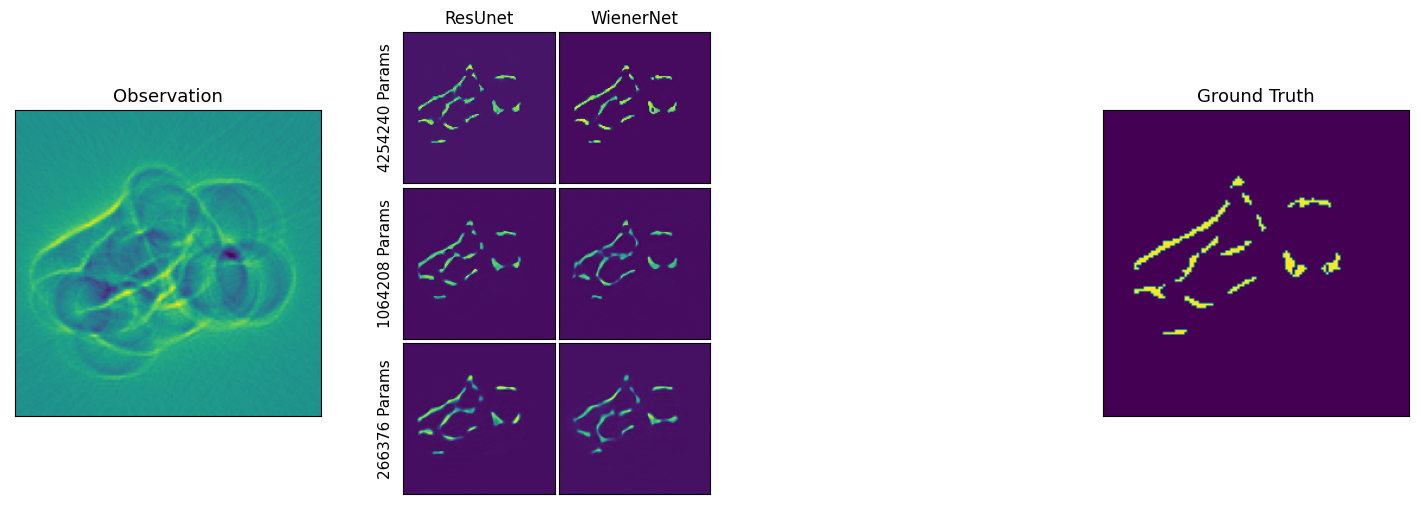

In [128]:
fig = plt.figure(figsize=(20,6), facecolor='white')
gs = gridspec.GridSpec(6, 20)

plt.subplot(gs[1:5,1:5])
plt.subplots_adjust(wspace=0.06, hspace=0.06)
plt.imshow(obs[3])
plt.xticks([])
plt.yticks([])
plt.title('Observation', fontsize=13)

plt.subplot(gs[1:5,15:19])
plt.subplots_adjust(wspace=0.06, hspace=0.06)
plt.imshow(gt)
plt.xticks([])
plt.yticks([])
plt.title('Ground Truth', fontsize=13)

for idx, (n_param, rec_res, rec_wiener) in enumerate(zip(n_params, rec_resunet, rec_wienernet)):
    plt.subplot(gs[2*idx:2*idx+2,6:8])
    plt.imshow(rec_res)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(f'{n_param} Params', fontsize=11)
    if idx == 0:
        plt.title('ResUnet', fontsize=12)
    
    ax1 = plt.subplot(gs[2*idx:2*idx+2,8:10])
    plt.imshow(rec_wiener)
    plt.xticks([])
    plt.yticks([])
    if idx == 0:
        plt.title('WienerNet', fontsize=12)
    # cax = fig.add_axes([ax1.get_position().x1+0.01, ax1.get_position().y0, 0.015, ax1.get_position().height])
    # cb = plt.colorbar(cax=cax)

    # plt.subplot(3,5,3)
    # plt.imshow(psf)
    # plt.title('PSF', fontsize=16)
    # plt.axis('off')

    # ax4 = plt.subplot(3,5,4)
    # plt.imshow(gt)
    # plt.title('Ground Truth', fontsize=16)
    # plt.axis('off')
    # cax = fig.add_axes([ax4.get_position().x1+0.01, ax4.get_position().y0, 0.015, ax4.get_position().height])
    # cb = plt.colorbar(cax=cax)
    